# Analyzing Language and Texts

[David J. Thomas](mailto:dave.a.base@gmail.com), [thePortus.com](http://thePortus.com)<br />
Instructor of Ancient History and Digital Humanities,<br />
Department of History,<br />
[University of South Florida](https://github.com/usf-portal)

---

## This workbook will...

* Use the `dhelp` module to access the `cltk` and `nltk` modules
* Preprocess the text for analysis
* POS (Part of Speech) tag each text
* Perform word counts
* Analyze several other features of the charter texts

---

## 1) Import Module Dependencies

The cell below loads all other Python packages needed. You **must** run this before any other cells.

In [1]:
import sqlalchemy as sql
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from nltk.text import Text, TextCollection
from dhelp import LatinText

## First Time Only Setup

The following cell MUST be run the first time you run this on a new computer. This will automatically use the `cltk` module to download training corpora and other necessary linguistic data.

In [ ]:
# installs nltk stopwords module
import nltk
nltk.download('stopwords')

# installs latin corpora/linguistic trainers
LatinText('').setup()

## 2) Configure Models 

In [73]:
engine = sql.create_engine('sqlite:///charters.db', echo=False)
Base = declarative_base()
    

class Charter(Base):
    __tablename__ = 'charters'

    id = sql.Column(sql.String, primary_key=True)
    description = sql.Column(sql.String)
    archive = sql.Column(sql.String)
    language = sql.Column(sql.String)
    scholarly_date_avg = sql.Column(sql.Float)
    text = sql.Column(sql.Text)
    
    @property
    def text_clean(self):
        """Basic text pre-processing, removes stopwords, extra spaces, and numbers, adds macrons"""
        stopwords = []
        with open('stopwords_latin.txt') as text_file:
            for line in text_file.readlines():
                stopwords.append(line)
        remove_chars = ['.', ',', ';', ':', '+', '-']
        altered_text = self.text
        for remove_char in remove_chars:
            altered_text = altered_text.replace(remove_char, '')
        return LatinText(altered_text.lower()
            ).rm_lines(
            ).normalize(
            ).rm_stopwords(stopwords
            ).rm_spaces()
    
    @property
    def text_lemmatized(self):
        """Gets the clean form of the text then transforms all words to their lemmata."""
        return self.text_clean.lemmatize()
    
    @property
    def entities(self):
        """Scans text with cltk's entity recognition and returns a list."""
        return LatinText(self.text).entities()
    
    def longest_common_substring(self, other_string):
        """Returns the longest substring that this and another charter share."""
        return LatinText(self.text).longest_common_substring(other_string)
    
    def compare_min_hash(self, other_string):
        """Compares the text minhash similarity of this and another charter."""
        return LatinText(self.text).compare_min_hash(other_string)
        
    def word_count(self):
        """Gives a dictionary, each key is a word appearing and the value is the count."""
        return LatinText(str(self.text_lemmatized)).word_count()
    
    def word_count_raw(self):
        """Same as .word_count(), but does not lemmatize words before counting."""
        return LatinText(self.text).word_count()
    
    def clausulae_count(self):
        """Similar to word_count, but instead uses cltk to look for poetic clausulae in prose text."""
        return LatinText(self.text).clausulae()


print('Model created successfully.')

Model created successfully.


In [74]:
cleaned_charters = []
lemmatized_charters = []

# open session, read texts from db and store in charters
session = sessionmaker(bind=engine)()

print('Preparing texts (lemmatizing and cleaning)...', end='')
counter = 0
for charter_obj in session.query(Charter):
    counter += 1
    cleaned_charters.append(Text(charter_obj.text_clean.tokenize()))
    lemmatized_charters.append(Text(charter_obj.text_lemmatized.tokenize()))
    if counter % 10 == 0:
        print('.', end='')
session.close()
print('Done!')

# converts charters from list of texts into text collection
cleaned_charters = TextCollection(cleaned_charters)
lemmatized_charters = TextCollection(lemmatized_charters)

Preparing texts (lemmatizing and cleaning).....................................Done!


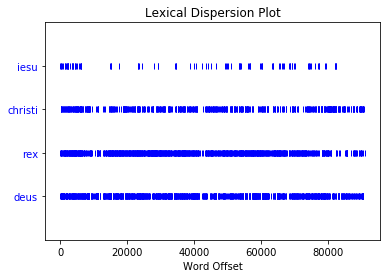

None


In [75]:
print(lemmatized_charters.dispersion_plot(['iesu', 'christi', 'rex', 'deus']))

In [76]:
print('Iesu')
print('Frequency to Document Ratio {}%'.format(round(lemmatized_charters.idf('iesu') * 100, 2)))

print('Concordance: First 10 appearances')
for concordance_appearance in lemmatized_charters.concordance_list('iesu')[0:10]:
    print(concordance_appearance.line)

Iesu
Frequency to Document Ratio 147.99%
Concordance: First 10 appearances
 iesu christo saluatore metior aprilio diu
s jubeo ego facio amen nomen dominus iesu christi omnis homo secundus1 deus vi
i 12 omne judex justus nomen dominus iesu christi nosco presentibus posterus æ
venio gloriee magnus deus saluatoris iesu christi beatus spes exspecto saluto 
erch ' nomen dominus deus saluatoris iesu christi lotharius rex cantuariorum a
 participatio corpus sanguis dominus iesu christi maneo cartula nichilominus f
 gratia deus subscribo nomen dominus iesu christi saluatoris suebhardus rex ca
xiu 34 nomen dominus deus saluatoris iesu christi oswynus rex cantie absolutio
t sum1 separo corpus sanguis dominus iesu christi maneo cartula perpetualiter 
rod signum manus1 eana nomen dominus iesu christi saluatoris oswinus rex cantu


In [77]:
print('Common Contexts')
print('\n---\nIesu:')
print(lemmatized_charters.common_contexts(['iesu']))
print('\n---\nRex:')
print(lemmatized_charters.common_contexts(['rex']))

Common Contexts

---
Iesu:
dominus_christo dominus_christi saluatoris_christi dominus_possessio
deus_christi ]_christo nomen_christi firmiter_christo
None

---
Rex:
æthelberhtus_filius æthilberhtus_cantie succedo_princeps
æthelbertus_cancie gratia_anglorum succedo_ullus athelbertus_anglorum
corroboraui_anglorum succedo_aliqua lotharius_cantuariorum noster_si
successorumque_cancie lotharius_cancie hlotharius_cantuariorum
eadricus_cantuariorum quondam_beatus ædricus_donatio
suebhardus_cantuariorum princeps_perdonatam successorumque_cantie
None


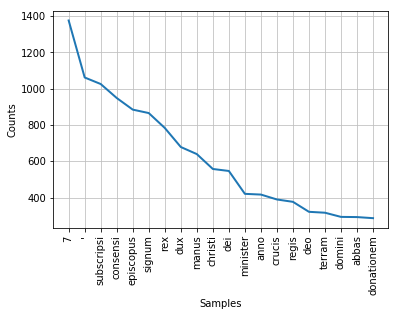

None


In [78]:
print(cleaned_charters.plot(20))

## MORE COMING SOON

For now, try out the network analysis module